In [32]:
import numpy as np
import matplotlib.pyplot as plt
import shapely
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict

In [33]:
#Loading the wine data and adding names of columns
data = pd.read_table('wine.data', sep=",", header=None, index_col = None 
                   ,names = ["Class", "Alcohol", "Malic acid", "Ash"
                    ,"Alcalinity of ash","Magnesium","Total phenols"
                    ,"Flavanoids","Nonflavanoid phenols","Proanthocyanins"
                    ,"Color Intensity","Hue","OD280/OD315 of diluted wines","Proline"]);

n_max = len(data.columns) - 1 

#Number of columns
X = data.iloc[:,1:14]
#Class vector
y = data.iloc[:,0]

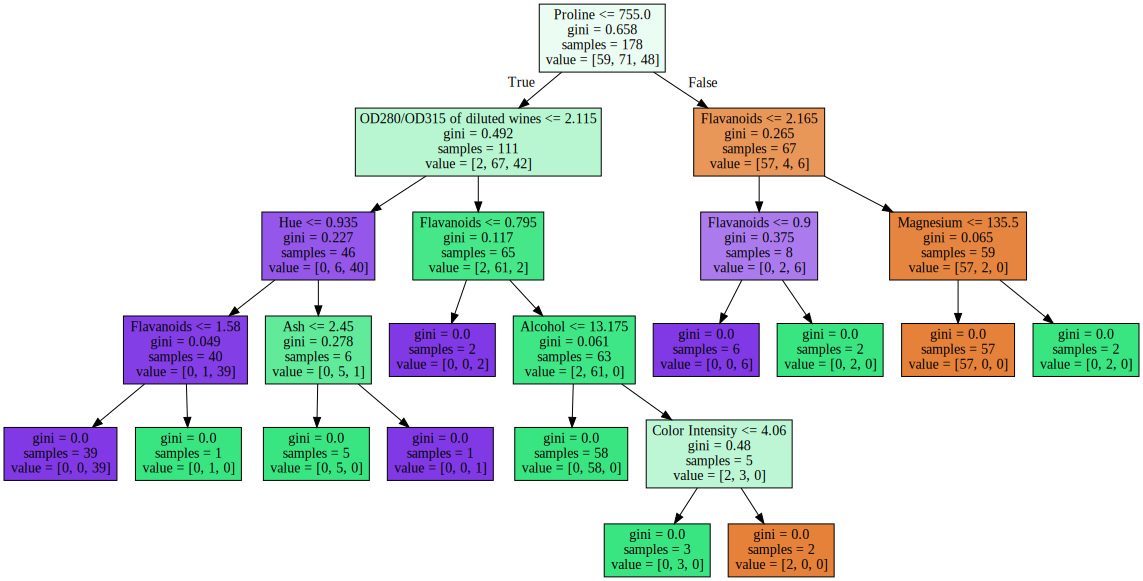

In [34]:
#Construction of decision tree classifier
tree = DecisionTreeClassifier()
tree.fit(X,y)
predictions = tree.predict(X)

#Graphical representation of above classifier
export_graphviz(tree, out_file="mytree.svg",feature_names = X.columns[0:], filled = True, rotate = False)
with open("mytree.svg") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [35]:
#Confusion matrix and accuracy for second substitution (its 1 because we changed nothing)
print(confusion_matrix(y,predictions))
print("Accuracy: ",accuracy_score(y, predictions))

[[59  0  0]
 [ 0 71  0]
 [ 0  0 48]]
Accuracy:  1.0


In [36]:
#Predicted values for ten-fold cross-validation 
cross_val_predictions = cross_val_predict(tree, X, y, cv=10)
#Confusion matrix and accuracy for ten-fold cross-validation
print(confusion_matrix(y,cross_val_predictions))
print("Accuracy: ",accuracy_score(y, cross_val_predictions))

[[55  4  0]
 [ 7 60  4]
 [ 2  8 38]]
Accuracy:  0.8595505617977528


In [37]:
#Searching for ccp_alphas in case of finding optimal decision tree
#implementation of cost complexity method 
opt_tree = DecisionTreeClassifier()
path = opt_tree.cost_complexity_pruning_path(X, y)
ccp_alphas = path.ccp_alphas

ccp_trees = []
for ccp_alpha in ccp_alphas:
    ccp_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    ccp_tree.fit(X, y)
    ccp_predictions = cross_val_predict(ccp_tree, X, y, cv=10)
    ccp_trees.append(accuracy_score(y, ccp_predictions))

In [38]:
#Checking which value of ccp_alha is the largest and allows
#to construct an optimal tree
print("Number of ccp_alpha is",ccp_trees.index(max(ccp_trees)),"and its value is", ccp_alphas[4])


Number of ccp_alpha is 4 and its value is 0.016853932584269662


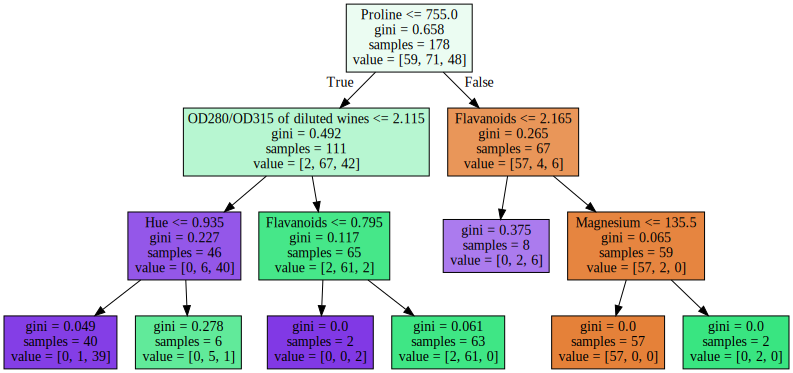

In [39]:
#Drawing optimal tree for calculated ccp_alpha
ccp_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alphas[4])
ccp_tree.fit(X, y)
ccp_opt_predictions = cross_val_predict(ccp_tree, X, y, cv=10)
    
export_graphviz(ccp_tree, out_file="opt_ccp_tree.svg",feature_names = X.columns[0:], filled = True, rotate = False)
with open("opt_ccp_tree.svg") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [40]:
#Confusion matrix and accuracy of classificator for ten-fold cross-validation - optimal tree
print("Optimal tree\n")
print(confusion_matrix(y,ccp_opt_predictions),"\n")
print("Accuracy: ",accuracy_score(y, ccp_opt_predictions),"\n")

#Confusion matrix and accuracy of classificator - full tree
print("Full tree\n")
print(confusion_matrix(y,cross_val_predictions),"\n")
print("Accuracy: ",accuracy_score(y, cross_val_predictions))

Optimal tree

[[55  4  0]
 [ 4 60  7]
 [ 0  6 42]] 

Accuracy:  0.8820224719101124 

Full tree

[[55  4  0]
 [ 7 60  4]
 [ 2  8 38]] 

Accuracy:  0.8595505617977528


Accuracy for optimal tree is higher than for full tree it means that optimization has sense and gives us valuable results

In [43]:
#Lists to compare optimal trees with full trees
full_leaves = []
full_trees_scores = []
opt_trees = []
opt_trees_scores = []
opt_leaves = []

for i in range(3,15):
    X = data.iloc[:,1:i]
    
    
    #Full tree
    full_tree = DecisionTreeClassifier()
    full_tree.fit(X,y)
    full_tree_predictions = cross_val_predict(full_tree, X, y, cv=10)
    full_trees_scores.append(accuracy_score(y,full_tree_predictions))
    
    #Leaves of full tree
    full_tree = DecisionTreeClassifier()
    full_tree.fit(X,y)
    full_leaves.append(full_tree.get_n_leaves())
    
    #Optimal tree 
    #path = d_tree.cost_complexity_pruning_path(X, y)
    ccp_alphas = path['ccp_alphas']
    opt_tree_scores = []
    for ccp_alpha in ccp_alphas:
        opt_tree = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
        opt_tree.fit(X, y)
        opt_tree_predictions = cross_val_predict(opt_tree, X, y, cv=10)
        opt_tree_scores.append(accuracy_score(y, opt_tree_predictions))
    opt_alpha = ccp_alphas[np.argmax(opt_tree_scores)]
    opt_acc = np.max(full_trees_scores)
    opt_trees_scores.append(opt_acc)
    
    #Leaves of optimal tree
    opt_tree = DecisionTreeClassifier(ccp_alpha=opt_alpha)
    opt_tree.fit(X,y)
    opt_leaves.append(opt_tree.get_n_leaves())
    
#Difference ov leaves  
def diffrence(list1,list2):
    diff = []
    for i in range(len(list1)):
        diff.append(list1[i]-list2[i])
    return diff
     

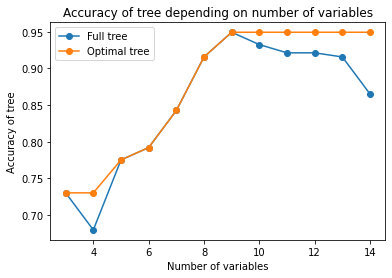

In [49]:
#Plotting the results 
fig, ax = plt.subplots()
ax.set_xlabel("Number of variables")
ax.set_ylabel("Accuracy of tree")
ax.set_title("Accuracy of tree depending on number of variables")
ax.plot(list(range(3,15)),full_trees_scores, label="Full tree",marker='o')
ax.plot(list(range(3,15)),opt_trees_scores, label="Optimal tree",marker='o')
#ax.plot(list(range(3,15)),diffrence(full_trees_scores,opt_trees_scores), label="Drzewo optymalne",marker='o')
ax.legend();

Accuracy for optimal tree is better for all number of variables. Also we can see that if we include 8 or more variables we have high accuracy of our method

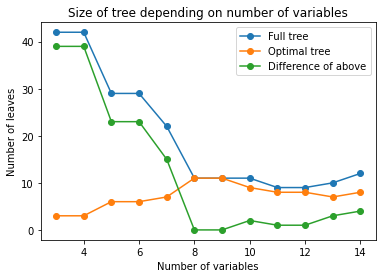

In [51]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of variables")
ax.set_ylabel("Number of leaves")
ax.set_title("Size of tree depending on number of variables")
ax.plot(list(range(3,15)),full_leaves, label="Full tree",marker='o')
ax.plot(list(range(3,15)),opt_leaves, label="Optimal tree",marker='o')
ax.plot(list(range(3,15)),diffrence(full_leaves,opt_leaves), label="Difference of above",marker='o')
ax.legend();

On above chart we observe that optimal tree gives us quite big reduction of number of leaves. If we include more than 8 variables full tree and optimal tree have common number of leaves. 